# Simulation with Noise and Errors

## Introduction
$\newcommand{\Ket}[1]{\left|#1\right>} \newcommand{\Bra}[1]{\left<#1\right|}$
This notebook gives an overview of how to simulate several kinds of noise in Pulser. Quantum computers aren't perfect and are susceptible to various sources of noise. In order to realistically simulate these quantum computations, we need to take them into account.

As of now, the types of noise implemented in Pulser are:

- SPAM (State Preparation And Measurement) errors : There are three types of such errors, one (with probability $\eta$) related to bad initial state preparation of the all-ground state $\Ket{g}^{\otimes n}$, and two (with probabilities $\epsilon, \epsilon '$) linked to detection errors. During the imaging process, excited Rydberg atoms in $\Ket{r}$ might decay to the state $\Ket{g}$, allowing them to be trapped in the tweezers : those are the false negatives modeled by $\epsilon'$. On the contrary, some atoms in $\Ket{g}$ might get excited due to various causes (collisions...) and tweezer recapture might fail, inferring them incorrectly as atoms in $\Ket{r}$ : those are the false positives modeled by $\epsilon$.

- Doppler damping : The atoms in the register are cooled to a temperature $T \sim 50\mu K$, which is low but still non-zero. Therefore, the laser frequency they observe is shifted by Doppler shifting due to thermal motion. This corresponds to a shift in the detuning frequency of the laser, and leads to a damping in the Rydberg population.

- Waist of the laser : For global pulses, the laser amplitude has a Gaussian profile and atoms at the border of the waist feel a slightly lower amplitude than those at the focus.

- Dephasing / phase-damping: Each qubit interacts with its environment, and we can model this interaction with random $Z$-rotations on each qubit. Given a dephasing probability $p$, this noise model adds two collapse operators $M_0 = \sqrt{1-\frac{p}{2}} \times \mathbb{1}$, $M_1 = \sqrt{\frac{p}{2}} \sigma_z = \sqrt{\frac{p}{2}} (\Ket{r}\Bra{r} - \Ket{g}\Bra{g})$ and forces the solver to adopt a density matrix formalism. See [here](https://ocw.mit.edu/courses/nuclear-engineering/22-51-quantum-theory-of-radiation-interactions-fall-2012/lecture-notes/MIT22_51F12_Ch8.pdf) for a more thorough explanation.


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import qutip

from pulser import Register, Pulse, Sequence, Simulation
from pulser.simulation import SimConfig
from pulser.devices import Chadoq2
from pulser.waveforms import ConstantWaveform, RampWaveform

## Single atom noisy simulations

### Sequence preparation

Prepare a single atom:

In [2]:
reg = Register.from_coordinates([(0, 0)], prefix="q")

Act on this atom with a Constant Pulse, such that it oscillates towards the excited Rydberg state and back to the original state (Rabi oscillations):

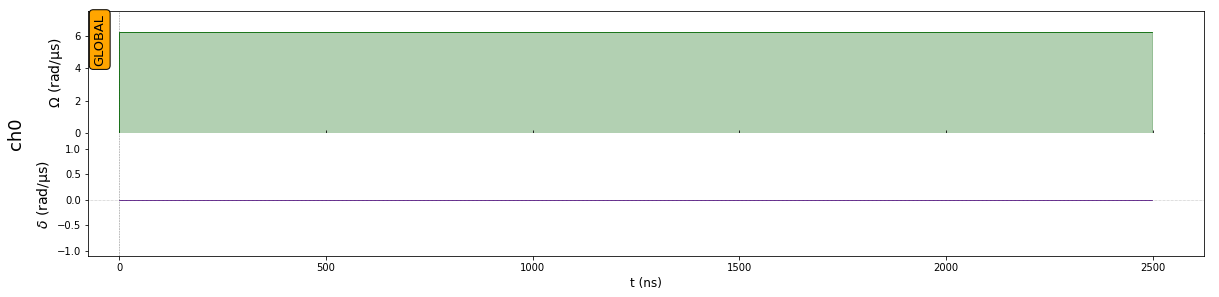

In [3]:
seq = Sequence(reg, Chadoq2)
seq.declare_channel("ch0", "rydberg_global")
duration = 2500
pulse = Pulse.ConstantPulse(duration, 2 * np.pi, 0.0, 0.0)
seq.add(pulse, "ch0")
seq.draw()

We now run the noiseless simulation, to obtain a `CoherentResults` object in `clean_res`.

In [4]:
sim = Simulation(seq, sampling_rate=0.05)
clean_res = sim.run()

Here we obtain the excited population using the projector onto the Rydberg state.

In [5]:
obs = qutip.basis(2, 0).proj()

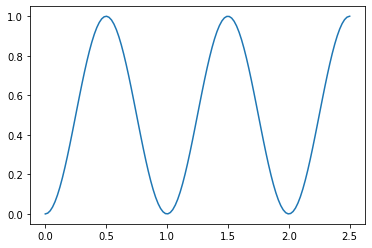

In [6]:
plt.plot(clean_res._sim_times, clean_res.expect([obs])[0])
plt.show()

### The SimConfig object

Each simulation has an associated `SimConfig` object, which encapsulates parameters such as noise types, the temperature of the register... You may view it at any time using the following command.

In [7]:
sim.show_config()

Options:
----------
Number of runs:        15
Samples per run:       5


When creating a new `SimConfig`, you may choose several parameters. `'runs'` indicates the number of times a noisy simulation is run to obtain the average result of several simulations, `'samples_per_run'` is the number of delivered samples per run - this has no physical interpretation, this is used simply to cut down on calculation time.

We will also add `SPAM` noise to the simulation by creating a new `SimConfig` object, and assigning it to the `config` field of `sim` via the `Simulation.set_config` setter. We pass noise types as a tuple of strings to a SimConfig object. Possible strings are : `'SPAM', 'dephasing', 'doppler', 'amplitude'`.

In [8]:
config_spam = SimConfig(noise=("SPAM"), runs=30, samples_per_run=5)
sim.set_config(config_spam)

We now show the new configuration to have an overview of the changes we made.

In [9]:
sim.show_config()

Options:
----------
Number of runs:        30
Samples per run:       5
Noise types:           SPAM
SPAM dictionary:       {'eta': 0.005, 'epsilon': 0.01, 'epsilon_prime': 0.05}


Note that `SimConfig.spam_dict` is the spam parameters dictionary. `eta` is the probability of a badly prepared state, `epsilon` the false positive probability, `epsilon_prime` the false negative one.

When dealing with a `SimConfig` object with different noise parameters from the config in `Simulation.config`, you may "add" both configurations together, obtaining a single `SimConfig` with all noises from both configurations. This adds simulation parameters to noises that weren't available in the former `Simulation.config`. Noises specified in both `SimConfigs` will keep the noise parameters in `Simulation.config`. Try it out with `Simulation.add_config`:

In [10]:
cfg2 = SimConfig(
    noise=("SPAM", "dephasing", "doppler"),
    eta=0.8,
    temperature=1000,
    runs=10000,
)
sim.add_config(cfg2)
sim.show_config()

Options:
----------
Number of runs:        30
Samples per run:       5
Noise types:           doppler, SPAM, dephasing
SPAM dictionary:       {'eta': 0.005, 'epsilon': 0.01, 'epsilon_prime': 0.05}
Temperature:           1000.0µK
Dephasing probability: 0.05


Note that we set the temperature in $\mu K$. We also observe that the `eta` parameter wasn't changed, since both `SimConfig` objects had `'SPAM'` as a noise model already. This feature might be useful when running several simulations with distinct noise parameters to observe the influence of each noise independtly, then wanting to combine noises together without losing your tailored noise parameters.

### Setting evaluation times

As a `Simulation` field, `eval_times` refers to the times at which the result have to be returned. Choose `'Full'` for all the times the Hamiltonian has been sampled in the sequence, a list of times of your choice (has to be a subset of all times in the simulation), or a real number between $0$ and $1$ to sample the full return times array. Here, we choose to keep $\frac{8}{10}$ of the Hamiltonian sample times for our evaluation times.

In [11]:
sim.evaluation_times = 0.8

We now obtain a `NoisyResults` object from our noisy simulation. This object represents the final result as a probability distribution over the sampled bitstrings, rather than a quantum state `QObj` in the `CleanResults` case.

In [12]:
res = sim.run()

### Plotting noisy and clean results

The new `res` instance has similar methods to the usual `SimResults` object. For example, we can calculate expectation values. Observe how different the Rydberg population in the clean case and noisy case are : we clearly see a damping due to all the noises we added.

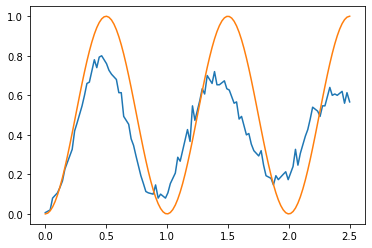

In [13]:
plt.plot(res._sim_times, res.expect([obs])[0])
plt.plot(clean_res._sim_times, clean_res.expect([obs])[0])
plt.show()

You can also use the `SimResults.plot(obs)` method to plot expectation values of a given observable. Here we compute the `sigma_z` local operator expectation values. You may choose to add error bars using the argument `error_bars = True` (`True` by default for `NoisyResults`.) Be wary that computing the expectation value of non-diagonal operators will raise an error, as `NoisyResults` bitstrings are already projected on the $Z$ basis.

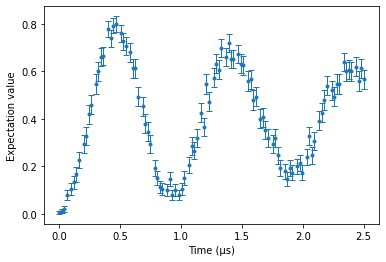

In [14]:
res.plot(obs, fmt=".")
plt.show()

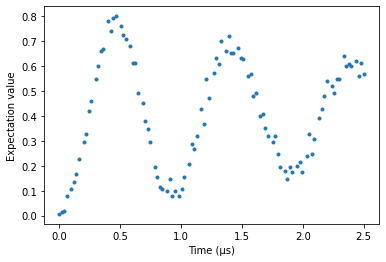

In [15]:
res.plot(obs, error_bars=False, fmt=".")

## SPAM effects

Compare both clean and noisy simulations for the default SPAM parameters (taken from [De Léséleuc, et al., 2018](https://arxiv.org/abs/1802.10424))

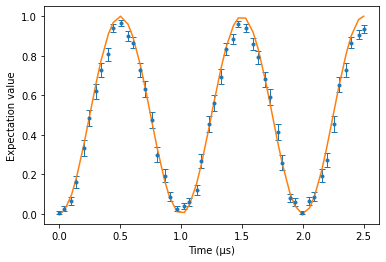

In [16]:
sim.set_config(config_spam)
sim.evaluation_times = 0.4
res_spam = sim.run()
res_spam.plot(obs)
sim.reset_config()
sim.eval_times = "Full"
res_clean = sim.run()
res_clean.plot(obs)
plt.show()

We will now modify the *SPAM* dictionary, as below, allowing for more ($40$%) badly prepared atoms.

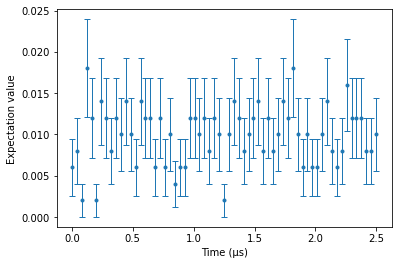

In [17]:
config_spam_mod = SimConfig(noise=("SPAM"), eta=0.4, runs=100)
sim.set_config(config_spam_mod)
sim.evaluation_times = 0.5
res_large_eta = sim.run()
res_large_eta.plot(obs)

We can see here that the population doesn't go well above $0.6 = 1 - \eta$, which is to be expected : badly prepared atoms don't reach state $\Ket{r}$. We can expect this limit of $0.6$ in the Rydberg population to be more and more respected as the number of runs grows.

### Changing $\eta$

Let us first initialize all spam error values to $0$. Then, we do a sweep over the parameter $\eta$, probability of badly prepared states, to notice its effects.

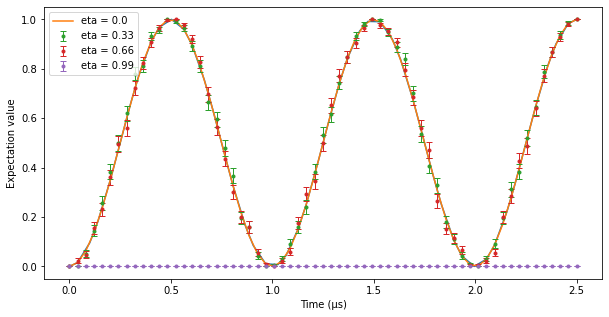

In [18]:
plt.figure(figsize=(10, 5))
res_clean.plot(obs)
for eta in np.linspace(0, 0.99, 4):
    config_spam_eta = SimConfig(
        noise="SPAM", eta=eta, runs=50, epsilon=0, epsilon_prime=0
    )
    sim.set_config(config_spam_eta)
    sim.run().plot(obs, label=f"eta = {eta}")
plt.legend()
plt.show()

As $\eta$ grows, more qubits are not well-prepared (i.e, pumped into a state different from $\Ket{g}$) and we stop seeing occupations at all. You may increase the number of runs to smooth the curves.

### Changing $\epsilon$

Let's now run a sweep over $\epsilon$.

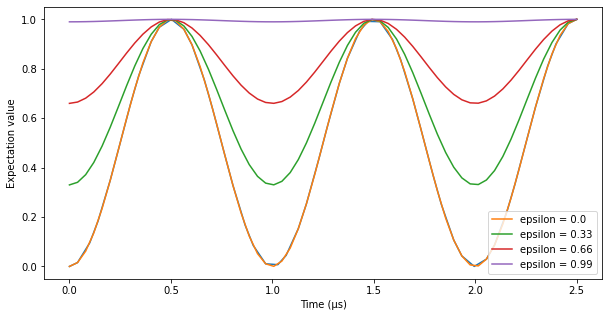

In [19]:
plt.figure(figsize=(10, 5))
res_clean.plot(obs)
for eps in np.linspace(0, 0.99, 4):
    config_spam_eps = SimConfig(
        noise="SPAM", eta=0, runs=50, epsilon=eps, epsilon_prime=0
    )
    sim.set_config(config_spam_eps)
    sim.run().plot(obs, label=f"epsilon = {eps}")
plt.legend()
plt.show()

As more false positives appear, it looks like the system is never captured, so always in a Rydberg state. Note that when $\eta=0$, the object we obtain is a `CoherentResults` rather than a `NoisyResults`, since in this case, the randomness comes from measurements and the simulation is entirely deterministic. This results in smooth curves rather than scattered dots.

### Changing $\epsilon'$

Finally, we run a sweep over $\epsilon'$.

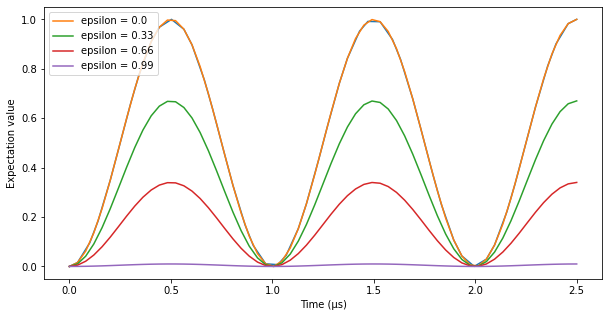

In [20]:
plt.figure(figsize=(10, 5))
res_clean.plot(obs)
for eps_p in np.linspace(0, 0.99, 4):
    config_spam_eps_p = SimConfig(
        noise="SPAM", eta=0, runs=50, epsilon=0, epsilon_prime=eps_p
    )
    sim.set_config(config_spam_eps_p)
    sim.run().plot(obs, label=f"epsilon = {eps_p}")
plt.legend()
plt.show()

As there are more false negatives, all atoms seem to be recaptured, until no Rydberg occupation is detected.

## Doppler Noise

As for any noise, Doppler noise is set via a `SimConfig` object. When averaging over several runs, it has the effect of damping the oscillations. Let's increase the number of runs in order to see this and get smoother curves.

Note that you may change the standard deviation of the doppler noise, which is $k \times \sqrt{k_B T / m}$, where $k$ is the norm of the effective wavevector of the lasers, by changing the temperature field, setting it in $\mu K$. We'll exaggerate the temperature field here to emphasize the effects of Doppler damping; the default value for temperature is 50$\mu K$.

In [21]:
config_doppler = SimConfig(
    noise="doppler", runs=100, temperature=5000, samples_per_run=1
)
sim.set_config(config_doppler)
sim.show_config()

Options:
----------
Number of runs:        100
Samples per run:       1
Noise types:           doppler
Temperature:           5000.0µK


Let us now simulate the entire sequence with Doppler noise, much like what we did in the SPAM case. We should see damped oscillations if the standard deviation is high enough. This is the case here, as we exaggerated the temperature field.

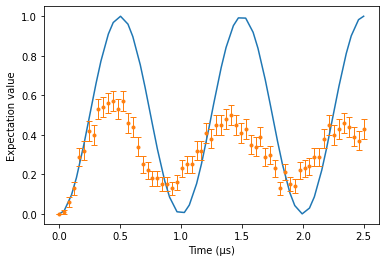

In [22]:
res_clean.plot(obs)
res_doppler = sim.run()
res_doppler.plot(obs)
plt.show()

## Multiple Atoms

We will now run the AFM preparation sequence from the Pulser tutorial with our noise models, and compare the results to the clean case. 

Note: We will not include dephasing / phase-damping, as the number of qubits ($9$ here) is too large and slows down the simulation, since the solver has to work with $2^9 \times 2^9$-dimensional matrices instead of $2^9$-dimensional kets.

In [23]:
# Parameters in rad/µs and ns
Omega_max = 2.3 * 2 * np.pi
U = Omega_max / 2.3
delta_0 = -6 * U
delta_f = 2 * U
t_rise = 252
t_fall = 500
t_sweep = (delta_f - delta_0) / (2 * np.pi * 10) * 1000
R_interatomic = Chadoq2.rydberg_blockade_radius(U)

N_side = 3
reg = Register.rectangle(N_side, N_side, R_interatomic, prefix="q")

rise = Pulse.ConstantDetuning(
    RampWaveform(t_rise, 0.0, Omega_max), delta_0, 0.0
)
sweep = Pulse.ConstantAmplitude(
    Omega_max, RampWaveform(t_sweep, delta_0, delta_f), 0.0
)
fall = Pulse.ConstantDetuning(
    RampWaveform(t_fall, Omega_max, 0.0), delta_f, 0.0
)

seq = Sequence(reg, Chadoq2)
seq.declare_channel("ising", "rydberg_global")

seq.add(rise, "ising")
seq.add(sweep, "ising")
seq.add(fall, "ising")

In [24]:
config_all_noise = SimConfig(
    noise=("SPAM", "doppler", "amplitude"), runs=100, samples_per_run=10
)
simul = Simulation(
    seq, sampling_rate=0.05, evaluation_times=0.2, config=config_all_noise
)
spam_results = simul.run()
simul.reset_config()
clean_results = simul.run()

We now plot the simulation results by sampling the final states.

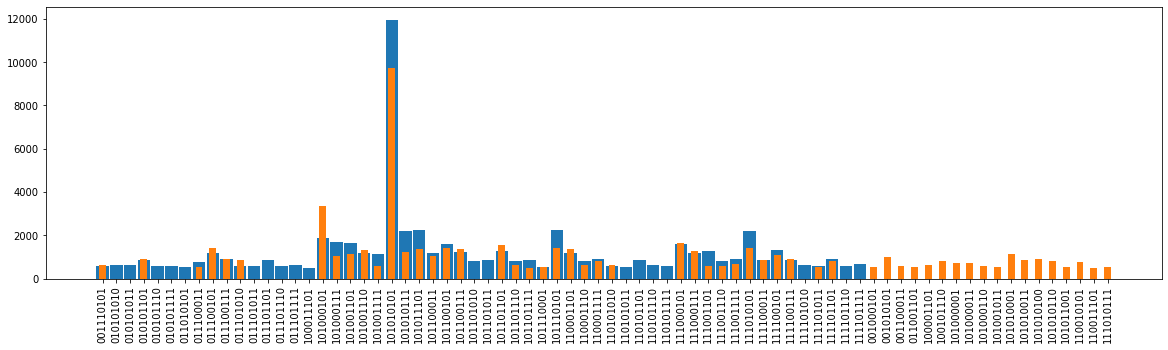

In [25]:
plt.figure(figsize=(20, 5))
spam_count = spam_results.sample_final_state(N_samples=1e5)
clean_count = clean_results.sample_final_state(N_samples=1e5)

clean_most_freq = {k: v for k, v in clean_count.items() if v > 500}
spam_most_freq = {k: v for k, v in spam_count.items() if v > 500}

plt.bar(
    list(clean_most_freq.keys()), list(clean_most_freq.values()), width=0.9
)
plt.bar(list(spam_most_freq.keys()), list(spam_most_freq.values()), width=0.5)

plt.xticks(rotation="vertical")
plt.show()

The bars represent the simulation results as populations of bitstrings. They're colored blue for the noiseless simulation, and orange for the noisy one. We clearly identify the antiferromagnetic state as the most populated one in both cases, but it is slightly less populated in the noisy case, while some other bitstrings, not present in the noiseless case, appear.